### Query:
What genes encode proteins that physically interact with proteins encoded by the EDS associated genes.

### Input:

Hardcoded tsv file from:

https://raw.githubusercontent.com/NCATS-Tangerine/cq-notebooks/master/FA_gene_sets/FA_1_core_complex.txt

### Goal:
This simple query aims to expand the FA-core gene set based PPI network membership.

### Route:
1. Protein-protein interactions from Monarch Solr index, either direct or inferred through orthology.  Sources: [BioGRID](https://thebiogrid.org/) and [STRING](http://string-db.org/)
2. Gene-ortholog associations from Monarch Solr index.  Sources: [Panther](http://www.pantherdb.org/)


In [2]:
import pandas as pd

/Users/putmanti/.virtualenvs/sandbox/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,gene,symbol
0,NCBIGene:1289,COL5A1
1,NCBIGene:1303,COL12A1
2,NCBIGene:7148,TNXB
3,NCBIGene:4638,MYLK
4,NCBIGene:4629,MYH11
5,NCBIGene:1277,COL1A1
6,NCBIGene:1278,COL1A2


In [135]:
import requests
import pandas as pd
import copy
core_set = 'https://raw.githubusercontent.com/kcortes133/EDS_Rotation/master/genes.txt'

columns = ['gene', 'interactor_id', 'interactor_symbol', 'qualifier', 'inferred_gene']
dataframe = pd.read_csv(core_set, sep="   ", names=['gene', 'symbol']) # sep on 3 spaces
dataframe
solr_url = 'https://solr.monarchinitiative.org/solr/golr/select'
def get_solr_results(solr, params):
    resultCount = params['rows']
    while params['start'] < resultCount:
        solr_request = requests.get(solr, params=params)
        response = solr_request.json()
        resultCount = response['response']['numFound']
        params['start'] += params['rows']
        for doc in response['response']['docs']:
            yield doc

interaction_params = {
    'wt': 'json',
    'rows': 100,
    'start': 0,
    'q': '*:*',
    'fl': 'subject, subject_label, subject_closure, \
           object, object_label, object_taxon',
    'fq': ['relation_closure: "RO:0002434"']
}

# Make new dataframe for results
interact_table = pd.DataFrame(columns=columns)


# Get interactions, both direct and inferred
for index, row in dataframe.iterrows():
    params = copy.deepcopy(interaction_params)
    params['fq'].append('subject_closure: "{0}" \
                        OR subject_ortholog_closure: "{0}"'
                        .format(row['gene']))
    for doc in get_solr_results(solr_url, params):
        result = {}
        result['gene'] = row['symbol']
        result['interactor_id'] = doc['object']
        result['interactor_symbol'] = doc['object_label']
        if row['gene'] in doc['subject_closure']:
            result['qualifier'] = "direct"
        else:
            result['qualifier'] = "homology"    
        interact_table = interact_table.append(result, ignore_index=True)
            
interact_table

/Users/putmanti/.virtualenvs/sandbox/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,gene,interactor_id,interactor_symbol,qualifier,inferred_gene
0,COL5A1,HGNC:9255,PPIB,direct,NaN
1,COL5A1,HGNC:9081,PLOD1,direct,NaN
2,COL5A1,HGNC:9083,PLOD3,direct,NaN
3,COL5A1,HGNC:9082,PLOD2,direct,NaN
4,COL5A1,HGNC:16171,CHMP4B,direct,NaN
...,...,...,...,...,...
695,COL1A2,HGNC:6156,ITGB3,direct,NaN
696,COL1A2,HGNC:6153,ITGB1,direct,NaN
697,COL1A2,HGNC:6150,ITGAV,direct,NaN
698,COL1A2,HGNC:6134,ITGA1,direct,NaN


In [136]:
interact_table2 = interact_table[interact_table['gene'].isin(["MYLK", "COL5A1"])]

In [137]:
interactors = interact_table2[['gene', 'interactor_symbol']].drop_duplicates()

In [138]:
all_interactors = interactors.value_counts('interactor_symbol').reset_index()
multi_interactors = all_interactors[all_interactors[0] > 1]

In [139]:
multi_interactors

,interactor_symbol,0
0,ITGB1,2
1,VIRMA,2
2,ANLN,2
3,ITGA1,2


In [140]:
include_interactors = multi_interactors["interactor_symbol"].tolist()

In [141]:
interact_table[interact_table["interactor_symbol"] == "LOX"]

,gene,interactor_id,interactor_symbol,qualifier,inferred_gene
545,COL1A1,HGNC:6664,LOX,direct,NaN
684,COL1A2,HGNC:6664,LOX,direct,NaN


In [142]:
import graphviz as gv

In [143]:
g = gv.Digraph()
nodes = list(set(interact_table['gene'].tolist())) + include_interactors
for node in nodes:
    g.node(node)
for row in interact_table.itertuples():
    if row.interactor_symbol in include_interactors:
        g.edge(row.gene, row.interactor_symbol, label="interacts_with")


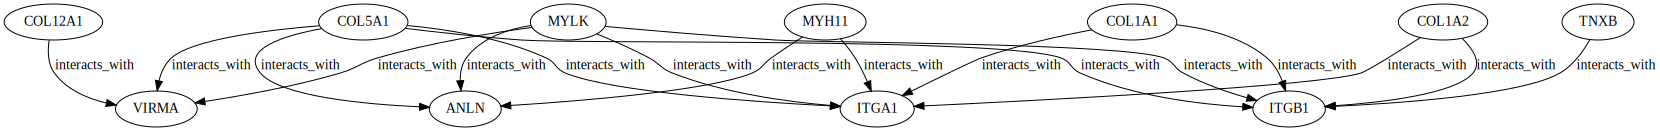

In [144]:
g

In [147]:
dataframe

,gene,symbol
0,NCBIGene:1289,COL5A1
1,NCBIGene:1303,COL12A1
2,NCBIGene:7148,TNXB
3,NCBIGene:4638,MYLK
4,NCBIGene:4629,MYH11
5,NCBIGene:1277,COL1A1
6,NCBIGene:1278,COL1A2


In [145]:
def pairwise_graph(list_of_genes):
    return graph of eds genes in list and only interactors that they share


SyntaxError: invalid syntax (1920336974.py, line 2)